<a href="https://colab.research.google.com/github/mutturajiu/BA05-TRIM02-Module-04-Text-Analytics-/blob/master/L%26T_Vehicle_Loan_Default.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import re
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
#from sklearn.ensemble import XGBClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_profiling

In [0]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

In [0]:
train=pd.read_csv('train.csv')

In [0]:
len(train.columns[:-1])

40

In [0]:
train.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,03-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,26-09-18,6,1998,1,1,0,0,0,0,598,I-Medium Risk,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,01-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,26-10-18,6,1998,1,1,0,0,0,0,305,L-Very High Risk,3,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,26-09-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


In [0]:
train.dtypes

UniqueID                                 int64
disbursed_amount                         int64
asset_cost                               int64
ltv                                    float64
branch_id                                int64
supplier_id                              int64
manufacturer_id                          int64
Current_pincode_ID                       int64
Date.of.Birth                           object
Employment.Type                         object
DisbursalDate                           object
State_ID                                 int64
Employee_code_ID                         int64
MobileNo_Avl_Flag                        int64
Aadhar_flag                              int64
PAN_flag                                 int64
VoterID_flag                             int64
Driving_flag                             int64
Passport_flag                            int64
PERFORM_CNS.SCORE                        int64
PERFORM_CNS.SCORE.DESCRIPTION           object
PRI.NO.OF.ACC

In [0]:
# Since, 'MobileNo_Avl_Flag' has 0 variance.. We will be dropping this feature
print(train.MobileNo_Avl_Flag.var())

0.0


In [0]:
train.drop(['UniqueID','MobileNo_Avl_Flag'], axis=1, inplace=True)

In [0]:
# Setting up time marker
d_marker= '21-04-19'
def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%d-%m-%y")
    d2 = datetime.strptime(d2, "%d-%m-%y")
    return abs((d2 - d1).days)

In [0]:
# age as on 1-1-2019 (in yrs)
train['Date.of.Birth'] = train['Date.of.Birth'].apply(lambda x:  days_between(x,d_marker)/365)
# Calculating time (in yrs) after disbursal
train['DisbursalDate']= train['DisbursalDate'].apply(lambda x:  days_between(x,d_marker)/365)

In [0]:
# Converting the given 'CREDIT.HISTORY.LENGTH' in months
train['CREDIT.HISTORY.LENGTH']= train['CREDIT.HISTORY.LENGTH'].apply(lambda x: (re.sub('[a-z]','',x)).split())
train['CREDIT.HISTORY.LENGTH']= train['CREDIT.HISTORY.LENGTH'].apply(lambda x: int(x[0])*12+int(x[1]))
# Converting the given 'AVERAGE.ACCT.AGE' in months
train['AVERAGE.ACCT.AGE']= train['AVERAGE.ACCT.AGE'].apply(lambda x: (re.sub('[a-z]','',x)).split())
train['AVERAGE.ACCT.AGE']= train['AVERAGE.ACCT.AGE'].apply(lambda x: int(x[0])*12+int(x[1]))

In [0]:
ct_col= ['branch_id','supplier_id', 'manufacturer_id', 'Current_pincode_ID', 'Employment.Type', 'State_ID', 'Employee_code_ID', 'Aadhar_flag', 'PAN_flag', 'VoterID_flag','Driving_flag', 'Passport_flag','PERFORM_CNS.SCORE.DESCRIPTION']


con_col= ['disbursed_amount', 'asset_cost', 'ltv','Date.of.Birth','DisbursalDate', 'PERFORM_CNS.SCORE', 'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS',
       'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT',
       'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS',
       'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT',
       'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES']

In [0]:
train[ct_col].head()

,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Employment.Type,State_ID,Employee_code_ID,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE.DESCRIPTION
0,67,22807,45,1441,Salaried,6,1998,1,0,0,0,0,No Bureau History Available
1,67,22807,45,1502,Self employed,6,1998,1,0,0,0,0,I-Medium Risk
2,67,22807,45,1497,Self employed,6,1998,1,0,0,0,0,No Bureau History Available
3,67,22807,45,1501,Self employed,6,1998,1,0,0,0,0,L-Very High Risk
4,67,22807,45,1495,Self employed,6,1998,1,0,0,0,0,No Bureau History Available


In [0]:
train.isnull().sum()

disbursed_amount                          0
asset_cost                                0
ltv                                       0
branch_id                                 0
supplier_id                               0
manufacturer_id                           0
Current_pincode_ID                        0
Date.of.Birth                             0
Employment.Type                        7661
DisbursalDate                             0
State_ID                                  0
Employee_code_ID                          0
Aadhar_flag                               0
PAN_flag                                  0
VoterID_flag                              0
Driving_flag                              0
Passport_flag                             0
PERFORM_CNS.SCORE                         0
PERFORM_CNS.SCORE.DESCRIPTION             0
PRI.NO.OF.ACCTS                           0
PRI.ACTIVE.ACCTS                          0
PRI.OVERDUE.ACCTS                         0
PRI.CURRENT.BALANCE             

In [0]:
eda_report=pandas_profiling.ProfileReport(data)
eda_report.to_file("Vehicle Loan Default_EDA_report.html")

NameError: ignored

In [0]:
train['Employment.Type'].value_counts()

Self employed    127635
Salaried          97858
Name: Employment.Type, dtype: int64

In [0]:
print('Percentage of missing values is {0}% for the training set'.format(round(100*train['Employment.Type'].isnull().sum()/len(train),2)))

Percentage of missing values is 3.29% for the training set


In [0]:
# Substituting the null values by third category 'unknown'
train.fillna('unknown', inplace=True)
train['Employment.Type'].value_counts()

Self employed    127635
Salaried          97858
unknown            7661
Name: Employment.Type, dtype: int64

In [0]:
le = LabelEncoder()
train.iloc[:,8] = le.fit_transform(train.iloc[:,8])
train.iloc[:,18] = le.fit_transform(train.iloc[:,18])

In [0]:
for i in con_col:
    train[i] = (train[i]- min(train[i])) / (max(train[i])- min(train[i]))

In [0]:
X= train.drop('loan_default', axis=1)
y= train.loan_default

In [0]:
train[ct_col].head()

,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Employment.Type,State_ID,Employee_code_ID,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE.DESCRIPTION
0,67,22807,45,1441,0,6,1998,1,0,0,0,0,13
1,67,22807,45,1502,1,6,1998,1,0,0,0,0,8
2,67,22807,45,1497,1,6,1998,1,0,0,0,0,13
3,67,22807,45,1501,1,6,1998,1,0,0,0,0,11
4,67,22807,45,1495,1,6,1998,1,0,0,0,0,13


In [0]:
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_profiling
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [0]:
train[ct_col].info()
train[ct_col].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Data columns (total 13 columns):
branch_id                        233154 non-null int64
supplier_id                      233154 non-null int64
manufacturer_id                  233154 non-null int64
Current_pincode_ID               233154 non-null int64
Employment.Type                  233154 non-null int64
State_ID                         233154 non-null int64
Employee_code_ID                 233154 non-null int64
Aadhar_flag                      233154 non-null int64
PAN_flag                         233154 non-null int64
VoterID_flag                     233154 non-null int64
Driving_flag                     233154 non-null int64
Passport_flag                    233154 non-null int64
PERFORM_CNS.SCORE.DESCRIPTION    233154 non-null int64
dtypes: int64(13)
memory usage: 23.1 MB


,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Employment.Type,State_ID,Employee_code_ID,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE.DESCRIPTION
count,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.00000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000
mean,72.936094,19638.635035,69.028054,3396.880247,0.613144,7.262243,1549.477148,0.84032,0.075577,0.144943,0.023242,0.002127,9.570794
std,69.834995,3491.949566,22.141304,2238.147502,0.550378,4.482230,975.261278,0.36631,0.264320,0.352044,0.150672,0.046074,5.087599
min,1.000000,10524.000000,45.000000,1.000000,0.000000,1.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,14.000000,16535.000000,48.000000,1511.000000,0.000000,4.000000,713.000000,1.00000,0.000000,0.000000,0.000000,0.000000,5.000000
50%,61.000000,20333.000000,86.000000,2970.000000,1.000000,6.000000,1451.000000,1.00000,0.000000,0.000000,0.000000,0.000000,13.000000
75%,130.000000,23000.000000,86.000000,5677.000000,1.000000,10.000000,2362.000000,1.00000,0.000000,0.000000,0.000000,0.000000,13.000000
max,261.000000,24803.000000,156.000000,7345.000000,2.000000,22.000000,3795.000000,1.00000,1.000000,1.000000,1.000000,1.000000,19.000000


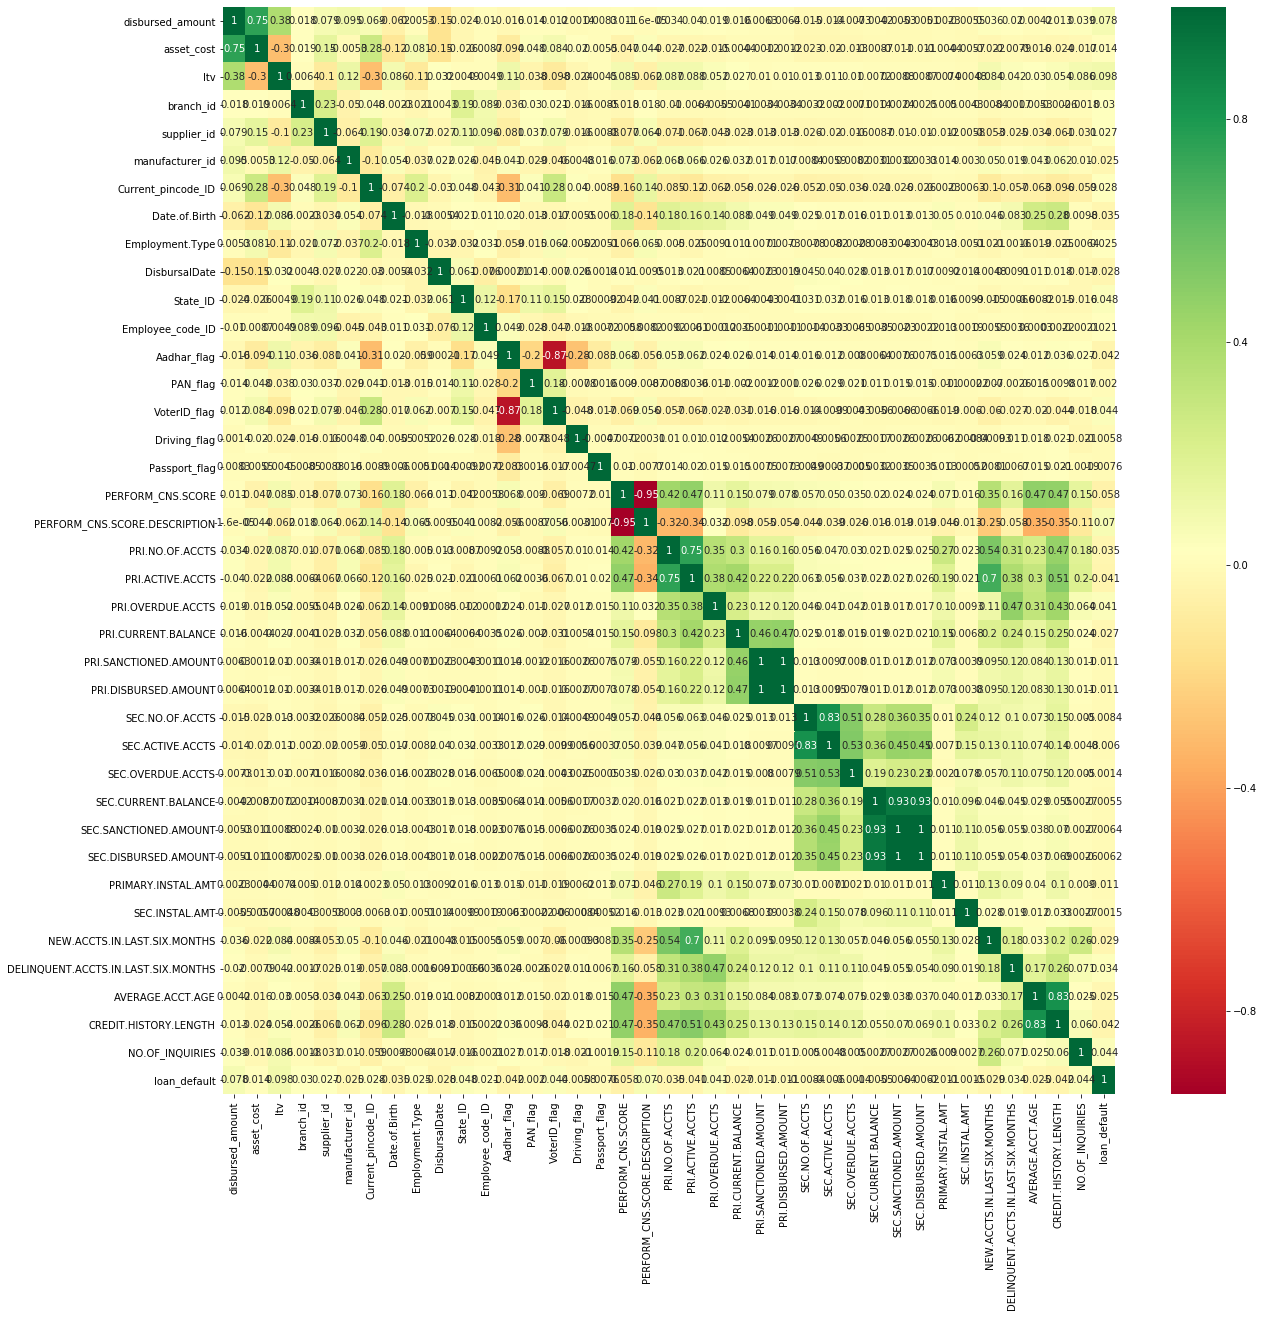

In [0]:
x=train.corr()
plt.subplots(figsize=(20,20))
sns.heatmap(x,cmap='RdYlGn',annot=True)
plt.show();

In [0]:
X= train.drop('loan_default', axis=1)
y= train.loan_default

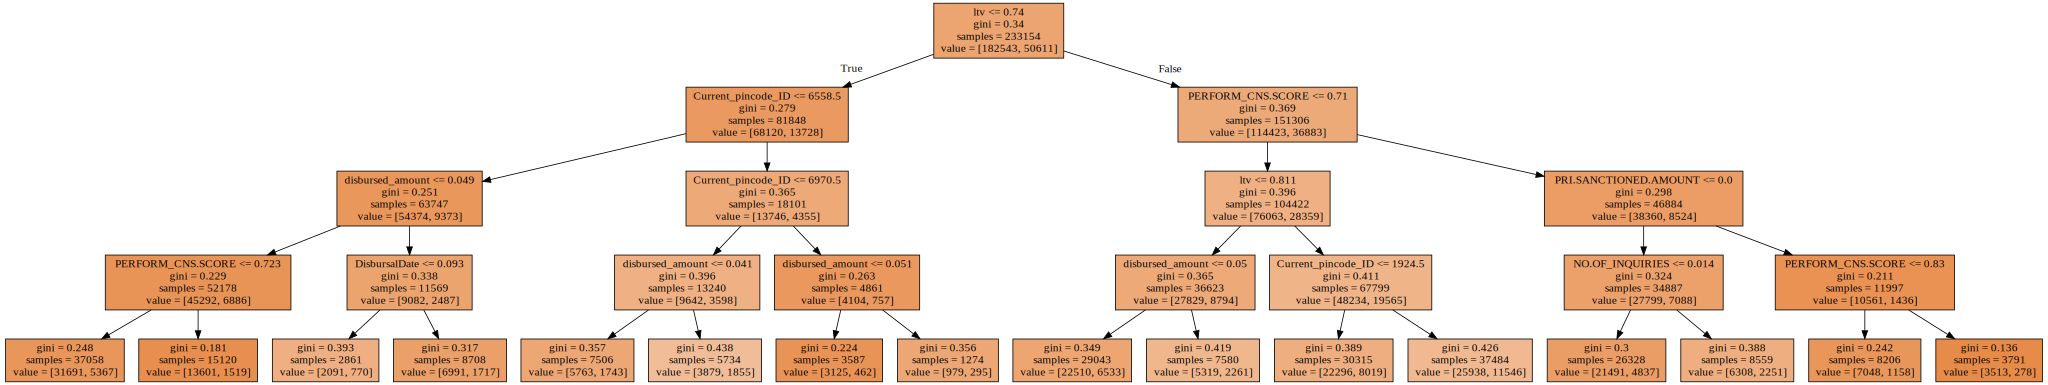

In [0]:
import graphviz
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=4)
clf = clf.fit(X,y)
with open('tree.dot','w') as dotfile:
    tree.export_graphviz(clf,out_file=dotfile,feature_names=X.columns,filled=True)
    dotfile.close()
    
from graphviz import Source
with open('tree.dot','r') as f:
    text=f.read()
    plot=Source(text)
plot

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [0]:
from sklearn import tree
my_tree_one = tree.DecisionTreeClassifier(max_depth=12)
my_tree_one
my_tree_one = my_tree_one.fit(X_train, y_train)
predicted = my_tree_one.predict(X_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=12,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [0]:
metrics.accuracy_score(predicted, y_train)

0.8008325764456554

In [0]:
my_tree_one.feature_importances_
X.columns
features = pd.DataFrame(my_tree_one.feature_importances_,X.columns)
features
features.columns = ["Importance"]
features

array([0.06148181, 0.04934489, 0.13761405, 0.02553619, 0.042023  ,
       0.01796211, 0.11785689, 0.06527955, 0.01248144, 0.06325042,
       0.02073722, 0.04658866, 0.00145484, 0.00162651, 0.00283384,
       0.00161267, 0.        , 0.08927639, 0.0047565 , 0.01474813,
       0.00958293, 0.01686409, 0.02318239, 0.02820616, 0.01863021,
       0.00147772, 0.00160572, 0.00222325, 0.00018965, 0.00071044,
       0.00147882, 0.02488555, 0.00104562, 0.00854303, 0.01307053,
       0.01825963, 0.02813309, 0.02544604])

Index(['disbursed_amount', 'asset_cost', 'ltv', 'branch_id', 'supplier_id',
       'manufacturer_id', 'Current_pincode_ID', 'Date.of.Birth',
       'Employment.Type', 'DisbursalDate', 'State_ID', 'Employee_code_ID',
       'Aadhar_flag', 'PAN_flag', 'VoterID_flag', 'Driving_flag',
       'Passport_flag', 'PERFORM_CNS.SCORE', 'PERFORM_CNS.SCORE.DESCRIPTION',
       'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS', 'PRI.OVERDUE.ACCTS',
       'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT', 'PRI.DISBURSED.AMOUNT',
       'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS', 'SEC.OVERDUE.ACCTS',
       'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT', 'SEC.DISBURSED.AMOUNT',
       'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT', 'NEW.ACCTS.IN.LAST.SIX.MONTHS',
       'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 'AVERAGE.ACCT.AGE',
       'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES'],
      dtype='object')

,0
disbursed_amount,0.061482
asset_cost,0.049345
ltv,0.137614
branch_id,0.025536
supplier_id,0.042023
manufacturer_id,0.017962
Current_pincode_ID,0.117857
Date.of.Birth,0.065280
Employment.Type,0.012481
DisbursalDate,0.063250


,Importance
disbursed_amount,0.061482
asset_cost,0.049345
ltv,0.137614
branch_id,0.025536
supplier_id,0.042023
manufacturer_id,0.017962
Current_pincode_ID,0.117857
Date.of.Birth,0.065280
Employment.Type,0.012481
DisbursalDate,0.063250


In [0]:
#Decision Tree Hyperparameters optimization using cross-validation 
criterion=['gini','entropy']
min_samples_split=[2,10,20,50,100]
max_depth=[20,30,None]

In [0]:
param_grid={'criterion':criterion, 'min_samples_split':min_samples_split,'max_depth':max_depth}
dt_g=GridSearchCV(my_tree_one, param_grid, cv=5,verbose = 2,n_jobs=-1)
dt_g.fit(X_train,y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.9min


KeyboardInterrupt: ignored

<Figure size 576x288 with 0 Axes>

Confusion Matrix


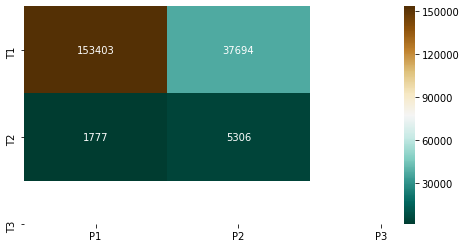

In [0]:
plt.figure(figsize=(8,4))
print('Confusion Matrix')
cf = metrics.confusion_matrix(predicted, y_train)
lbl1=["P1", "P2", "P3"]
lbl2 = ["T1", "T2", "T3"]
sns.heatmap(cf,annot=True,cmap ="BrBG_r", fmt="d", xticklabels=lbl1,yticklabels=lbl2)
plt.show()

In [0]:
dt_g.best_estimator_

In [0]:
dt_g.best_score_

In [0]:
cv=pd.DataFrame(dt_g.cv_results_)
cv